In [13]:
import numpy as np 
from itertools import combinations
from tqdm import tqdm
from matplotlib import pyplot as plt

np.random.seed(42)

# Cellular sheaves on graphs 
## Learning sheaf laplacian through minimum total variation approach 

### Generating a toy-case topology

In [2]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,2),
    (0,6),
    (1,3),
    (1,5),
    (2,3),
    (2,4),
    (3,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

In [3]:
d = 3                                           # Node and edges stalks dimension

F = {
    e:{
        e[0]:np.random.randn(3,3),
        e[1]:np.random.randn(3,3)
        } 
        for e in edges
    }                                           # Incidency linear maps

In [4]:
# Graph representation

A = np.zeros((7,7))

for edge in edges:
    u = edge[0] 
    v = edge[1] 

    A[u,v] = 1
    A[v,u] = 1

D = np.diag(np.sum(A, axis = 0))
L = D - A

In [5]:
# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B_u = F[edge][u]
    B_v = F[edge][v]

    B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

# Sheaf Laplacian
L_f = B.T @ B

### Generating a smooth signals dataset 

*(from Hansen J., "Learning sheaf Laplacians from smooth signals")* 

In order to retrieve a dataset of smoothsignals, first of all we sample random gaussians vectors on the nodes of the graph. Then we smooth them according to their expansion in terms of the eigenvectors of the sheaf Laplacian $L_0$.

So let's firstly define a dataset of random gaussian vectors. 

In [6]:
N = 100
X = np.random.randn(V*d,N)

Now we'll use the Fourier-domain embedded in the Laplacian spectrum. 

We'll consider a Tikhonov inspired procedure where we firstly project our dataset over the space spanned by the eigenvectors of the sheaf laplacian: namely $U$ the matrix collecting this eigenvectors we have 
\begin{equation}
    \hat{x} = U^T x
\end{equation}

So that defining $h(\lambda) = \frac{1}{1 + 10\lambda}$ and $H = \mathrm{diag}\{h(\lambda)\}_{\lambda}$, we now have

\begin{equation}
    \hat{y} = H(\Lambda) \hat{x}
\end{equation}

and finally our dataset is just reprojected back into the vertex domain:

\begin{equation}
    y = U H(\Lambda) \hat{x} = U H(\Lambda) U^T x
\end{equation}

In [7]:
Lambda, U = np.linalg.eig(L_f)
H = 1/(1 + 10*Lambda)

In [8]:
Y = U @ np.diag(H) @ U.T @ X

Y += np.random.normal(0, 10e-2, size=Y.shape)

We can observe the different overall total variation from the original random sampled dataset of signals and the filtered one: 

In [9]:
np.trace(X.T @ L_f @ X)

16119.899062147002

In [10]:
np.trace(Y.T @ L_f @ Y)

174.55977674934778

Now we deploy the linear map learning strategy. If we consider each of the linear maps connecting the stalks over the nodes with the stalk of the inciding edge, we have that the minimum total variation on the Laplacian can be rewritten as (considering also a penalizing term that ensures that we avoid the trivial all-zero solutions *[Vassilis Kalofolias. “How to Learn a Graph from Smooth Signals.” In:
Journal of Machine Learning Research (JMLR) (2016)]*):

\begin{equation}
    \min_{\mathcal{F}_{u \triangleleft e}, \mathcal{F}_{v \triangleleft e}, e \in E} \frac{1}{2} \sum_{e \in E} \sum_{i=1}^N ||\mathcal{F}_{u \triangleleft e}x_u^i - \mathcal{F}_{v \triangleleft e}x_v^i||_F^2 - \lambda_u \log(\det(\mathcal{F}_{u \triangleleft e})) - \lambda_v \log(\det(\mathcal{F}_{v \triangleleft e}))
\end{equation}

Clearly this problem can be decomposed into the contribution of each of the edges, requiring us to solve a subproblem for each of the possible edges: 

\begin{equation}
    \min_{\mathcal{F}_{u \triangleleft e}, \mathcal{F}_{v \triangleleft e}} \frac{1}{2} \sum_{i=1}^N ||\mathcal{F}_{u \triangleleft e}x_u^i - \mathcal{F}_{v \triangleleft e}x_v^i||_F^2 - \lambda_u \log(\det(\mathcal{F}_{u \triangleleft e})) - \lambda_v \log(\det(\mathcal{F}_{v \triangleleft e}))
\end{equation}

This problem can be solved in a successive convex approximation fashion, being block-wise convex. The update equations are the following, leveraging the results of *H. H. Bauschke and P. L. Combettes: Convex Analysis and Monotone Operator Theory in Hilbert Spaces (2nd Edition). Springer, New York, 2017* in deriving the proximal mapping of the logdet of a matrix. In particular, given $X \in \mathbb{R}^{n \times n}$ and its spectral decomposition $X = U^T \mathrm{Diag}(s) U$, the proximal mapping of $-\log\det(X)$ is
 
\begin{equation}
\mathrm{prox}_{-\gamma\log\det(X)} = U \ \mathrm{Diag}(z) \ U^T, \ z = \frac{1}{2}(s + \sqrt{s^2 + 4\gamma})
\end{equation}

So finally our successive convex approximation follows the following update rules for $t = 0, ..., T$: 

\begin{gather}
    \hat{{\mathcal{F}}}_{u \triangleleft e} = \mathrm{prox}_{-\lambda_u\log\det()}[{\mathcal{F}_{v \triangleleft e}^t} (X_vX_u^T) (X_uX_u^T)^{-1}] \\ \nonumber
    \hat{{\mathcal{F}}}_{v \triangleleft e} = \mathrm{prox}_{-\lambda_v\log\det()}[{\mathcal{F}_{u \triangleleft e}^t} (X_uX_v^T) (X_vX_v^T)^{-1}] \\ \nonumber
    {\mathcal{F}}_{u \triangleleft e}^{t+1} = {\mathcal{F}}_{u \triangleleft e}^t - \eta^t [{\hat{\mathcal{F}}_{u \triangleleft e}} - {\mathcal{F}}_{u \triangleleft e}^t] \\ \nonumber
    {\mathcal{F}}_{v \triangleleft e}^{t+1} = {\mathcal{F}}_{v \triangleleft e}^t - \eta^t [{\hat{\mathcal{F}}_{v \triangleleft e}} - {\mathcal{F}}_{v \triangleleft e}^t]
\end{gather}

In the end we can compute the total energy related to each edge: this means that if we sort out all the edges with respect to this measure we can rebuild the laplacian considering the given $t_0$ number of edges and the associated linear maps. 

In [11]:
'''
def pseudo_solver_A(A, B, X, Y, L, M = 50):
    A_ = A.T
    for _ in range(M):
        A_ -= np.linalg.inv(2*A_ @ X - B @ Y @ X.T) @ (A_.T @ X @ X.T @ A - B @ Y @ X.T @ A_ - L*np.eye(A_.shape[0]))
    return A_.T

def pseudo_solver_B(A, B, X, Y, L, M = 50):
    B_ = B.T
    for _ in range(M):
        B_ -= np.linalg.inv(2*B_ @ Y - A @ X @ Y.T) @ (B_.T @ Y @ Y.T @ B - A @ X @ Y.T @ B_ - L*np.eye(B_.shape[0]))
    return B_.T
'''

'\ndef pseudo_solver_A(A, B, X, Y, L, M = 50):\n    A_ = A.T\n    for _ in range(M):\n        A_ -= np.linalg.inv(2*A_ @ X - B @ Y @ X.T) @ (A_.T @ X @ X.T @ A - B @ Y @ X.T @ A_ - L*np.eye(A_.shape[0]))\n    return A_.T\n\ndef pseudo_solver_B(A, B, X, Y, L, M = 50):\n    B_ = B.T\n    for _ in range(M):\n        B_ -= np.linalg.inv(2*B_ @ Y - A @ X @ Y.T) @ (B_.T @ Y @ Y.T @ B - A @ X @ Y.T @ B_ - L*np.eye(B_.shape[0]))\n    return B_.T\n'

In [12]:
# Alternated Linear Maps Learning

def ALML(X_u, X_v, d, lambda_v = 0.5, lambda_u = 0.5, T = 500):
    # Initialization 

    F_u = np.random.randn(d,d)
    F_v = np.random.randn(d,d)
    gamma = 0.99

    # This matrices can be computed out of the learning loop 

    vu = X_v @ X_u.T
    uv = X_u @ X_v.T
    uu = np.linalg.inv(X_u @ X_u.T)
    vv = np.linalg.inv(X_v @ X_v.T)

    # Alternated learning through blockwise convex programs

    for _ in range(T): 

        # Local step

        # Close form without regularization
        F_u_hat = F_v @ vu @ uu 
        F_v_hat = F_u @ uv @ vv 

        # Proximal mapping
        s_u, U_u = np.linalg.eig(F_u_hat)
        z_u = 0.5*(s_u + np.sqrt(s_u**2 + 4*lambda_u))
        F_u_hat = U_u @ np.diag(z_u) @ U_u.T
        
        s_v, U_v = np.linalg.eig(F_v_hat)
        z_v = 0.5*(s_v + np.sqrt(s_v**2 + 4*lambda_v))
        F_v_hat = U_v @ np.diag(z_v) @ U_v.T
        
        '''
        # Pseudo solving
        F_u_hat = pseudo_solver_A(F_u, F_v, X_u, X_v, lambda_u)
        F_v_hat = pseudo_solver_A(F_v, F_v, X_u, X_v, lambda_u)
        '''
        # Convex smoothing
        F_u = F_u + gamma*(F_u_hat - F_u)
        F_v = F_v + gamma*(F_v_hat - F_v)

        gamma *= 0.9
        
    return F_u, F_v 

In [13]:
all_edges = list(combinations(nodes, 2))
maps = {
    e:{
        e[0] : np.zeros((3,3)), 
        e[1] : np.zeros((3,3))
        } 
    for e in all_edges
    }

energies = {
    e : 0
    for e in all_edges
    }

In [14]:
for e in tqdm(all_edges):
    u = e[0]
    v = e[1]

    X_u = Y[u*d:(u+1)*d,:]
    X_v = Y[v*d:(v+1)*d,:]

    F_u, F_v = ALML(X_u, X_v, d, T = 500)

    maps[e][u] = F_u
    maps[e][v] = F_v

    L = 0

    for i in range(100):
        x_u = X_u[:,i]
        x_v = X_v[:,i]
        L += np.linalg.norm(F_u @ x_u - F_v @ x_v)
        
    energies[e] = L

 14%|█▍        | 3/21 [00:00<00:00, 26.34it/s]

100%|██████████| 21/21 [00:00<00:00, 25.69it/s]


In [15]:
retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]

In [16]:
B_hat = np.zeros((d*E, d*V))

for i in range(10):
    edge = retrieved[i][0]

    u = edge[0] 
    v = edge[1] 

    B_u = maps[edge][u]
    B_v = maps[edge][v]

    B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
    B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

L_f_hat = B_hat.T @ B_hat

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9568\3707325050.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_9568\3707325050.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v


In [17]:
# The metric chosen by Hansen for the evaluation was the average entry-wise euclidean distance

np.sqrt(np.sum((L_f - L_f_hat)**2)) / L_f.size

0.08978437592894238

In [18]:
len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E

0.6

In [19]:
edges

[(0, 1),
 (0, 2),
 (0, 6),
 (1, 3),
 (1, 5),
 (2, 3),
 (2, 4),
 (3, 4),
 (4, 6),
 (5, 6)]

In [20]:
retrieved

[((1, 3), 18.696234875831763),
 ((0, 1), 20.592146161160024),
 ((3, 6), 22.334289138161495),
 ((0, 2), 22.445539715360624),
 ((0, 5), 22.778776907905737),
 ((5, 6), 22.87604746880256),
 ((1, 5), 23.222191438235114),
 ((1, 6), 23.279038540201903),
 ((0, 6), 23.445152941046427),
 ((2, 6), 23.701680669108963)]

# Extended simulation 

In [2]:
# Alternated Linear Maps Learning

def ALML(X_u, X_v, d, lambda_v = 0.5, lambda_u = 0.5, T = 500):
    # Initialization 

    F_u = np.random.randn(d,d)
    F_v = np.random.randn(d,d)
    gamma = 0.99

    # This matrices can be computed out of the learning loop 

    vu = X_v @ X_u.T
    uv = X_u @ X_v.T
    uu = np.linalg.inv(X_u @ X_u.T)
    vv = np.linalg.inv(X_v @ X_v.T)

    # Alternated learning through blockwise convex programs

    for _ in range(T): 

        # Local step

        # Close form without regularization
        F_u_hat = F_v @ vu @ uu 
        F_v_hat = F_u @ uv @ vv 

        # Proximal mapping
        s_u, U_u = np.linalg.eig(F_u_hat)
        z_u = 0.5*(s_u + np.sqrt(s_u**2 + 4*lambda_u))
        F_u_hat = U_u @ np.diag(z_u) @ U_u.T
        
        s_v, U_v = np.linalg.eig(F_v_hat)
        z_v = 0.5*(s_v + np.sqrt(s_v**2 + 4*lambda_v))
        F_v_hat = U_v @ np.diag(z_v) @ U_v.T
        
        '''
        # Pseudo solving
        F_u_hat = pseudo_solver_A(F_u, F_v, X_u, X_v, lambda_u)
        F_v_hat = pseudo_solver_A(F_v, F_v, X_u, X_v, lambda_u)
        '''
        # Convex smoothing
        F_u = F_u + gamma*(F_u_hat - F_u)
        F_v = F_v + gamma*(F_v_hat - F_v)

        gamma *= 0.9
        
    return F_u, F_v 

In [3]:
def simulation(V = 100, d = 3):
    nodes = [n for n in range(V)]
    edges = []

    for u in range(V):
        for v in range(u, V):
            p = np.random.uniform(0,1,1)
            if p > 1.1*np.log(V)/V:
                edges.append((u,v))

    E = len(edges)
    F = {
        e:{
            e[0]:np.random.randn(d,d),
            e[1]:np.random.randn(d,d)
            } 
            for e in edges
        }                                           # Incidency linear maps

    #_______________________
    # Sheaf representation 

    B = np.zeros((d*E, d*V))                        # Coboundary maps

    for i in range(len(edges)):

        # Main loop to populate the coboundary map

        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u           
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    L_f = B.T @ B

    #_______________________

    N = 100
    X = np.random.randn(V*d,N) 

    # Spectral representation of the sheaf laplacian
    Lambda, U = np.linalg.eig(L_f)

    # Functional for filtering remapping the eigenvals in [0,1]
    H = 1/(1 + 10*Lambda) 

    
    Y = (U @                                        # Project back into the nodes domain
         np.diag(H) @                               # Filter out in a Tikhonov fashion
         U.T @ X                                    # Project gaussian random vectors in the Fourier domain of the sheaf laplacian 
    )

    Y += np.random.normal(0, 10e-2, Y.shape)
    
    all_edges = list(combinations(nodes, 2))
    maps = {
        e:{
            e[0] : np.zeros((d,d)), 
            e[1] : np.zeros((d,d))
            } 
        for e in all_edges
        }

    energies = {
        e : 0
        for e in all_edges
        }

    for e in all_edges:
        u = e[0]
        v = e[1]

        X_u = Y[u*d:(u+1)*d,:]
        X_v = Y[v*d:(v+1)*d,:]

        F_u, F_v = ALML(X_u, X_v, d, T = 500)

        maps[e][u] = F_u
        maps[e][v] = F_v

        L = 0

        for i in range(100):
            x_u = X_u[:,i]
            x_v = X_v[:,i]
            L += np.linalg.norm(F_u @ x_u - F_v @ x_v)
            
        energies[e] = L

    retrieved = sorted(energies.items(), key=lambda x:x[1])[:E]
    B_hat = np.zeros((d*E, d*V))

    for i in range(E):
        edge = retrieved[i][0]

        u = edge[0] 
        v = edge[1] 

        B_u = maps[edge][u]
        B_v = maps[edge][v]

        B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    L_f_hat = B_hat.T @ B_hat

    return {
        "AvgEntryWiseED_L2" : np.sqrt(np.sum((L_f - L_f_hat)**2)) / L_f.size,
        "AvgEntryWiseED_L1" : np.sqrt(np.sum(np.abs(L_f - L_f_hat))) / L_f.size,
        "SparsityAccuracy" : len(set(list(map(lambda x: x[0], retrieved))).intersection(set(edges))) / E
        }

In [ ]:
T = 20
sims_1_avgDist_L2 = [0 for _ in range(T)]
sims_1_avgDist_L1 = [0 for _ in range(T)]
sims_1_sparsAcc = [0 for _ in range(T)]

sims_2_avgDist_L2 = [0 for _ in range(T)]
sims_2_avgDist_L1 = [0 for _ in range(T)]
sims_2_sparsAcc = [0 for _ in range(T)]

for t in range(T):
    simu_1 = simulation(V = 100, d = 1)

    sims_1_avgDist_L2[t] = simu_1["AvgEntryWiseED_L2"]
    sims_1_avgDist_L1[t] = simu_1["AvgEntryWiseED_L1"]
    sims_1_sparsAcc[t] = simu_1["SparsityAccuracy"]

    simu_2 = simulation(V = 50, d = 2)

    sims_2_avgDist_L2[t] = simu_2["AvgEntryWiseED_L2"]
    sims_2_avgDist_L1[t] = simu_2["AvgEntryWiseED_L1"]
    sims_2_sparsAcc[t] = simu_2["SparsityAccuracy"]

In [23]:
AVG_sims_1_avgDist_L2 = sum(sims_1_avgDist_L2) / T
AVG_sims_1_avgDist_L1 = sum(sims_1_avgDist_L1) / T
AVG_sims_1_sparsAcc = sum(sims_1_sparsAcc) / T

AVG_sims_2_avgDist_L2 = sum(sims_2_avgDist_L2) / T
AVG_sims_2_avgDist_L1 = sum(sims_2_avgDist_L1) / T
AVG_sims_2_sparsAcc = sum(sims_2_sparsAcc) / T

In [24]:
print("Average entry-wise reconstruction L2 error, V = 100, d = 1:", AVG_sims_1_avgDist_L2)
print("Average entry-wise reconstruction L1 error, V = 100, d = 1:", AVG_sims_1_avgDist_L1)
print("Average precision in recovering underlying graph, V = 100, d = 1:", AVG_sims_1_sparsAcc)

Average entry-wise reconstruction L2 error, V = 100, d = 1: 0.04958770606042204
Average entry-wise reconstruction L1 error, V = 100, d = 1: 0.011208888375829082
Average precision in recovering underlying graph, V = 100, d = 1: 0.9492141154684021


In [25]:
print("Average entry-wise reconstruction L1 error, V = 100, d = 1:", AVG_sims_2_avgDist_L2)
print("Average entry-wise reconstruction L2 error, V = 100, d = 1: ", AVG_sims_2_avgDist_L1)
print("Average precision in recovering underlying graph, V = 50, d = 2: ", AVG_sims_2_sparsAcc)

Average entry-wise reconstruction L1 error, V = 100, d = 1: 0.06534351956851694
Average entry-wise reconstruction L2 error, V = 100, d = 1:  0.013181177881945779
Average precision in recovering underlying graph, V = 50, d = 2:  0.9151004705301506


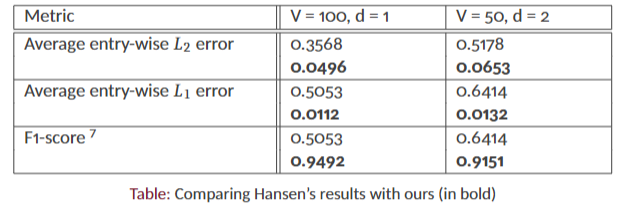

# Fixing V = 50, let's run it for stalks dimensions up to 15

In [7]:
T = 10
D = 15

sims_1_avgDist_L2 = {d:[0 for _ in range(T)] for d in range(3,D)}
sims_1_avgDist_L1 = {d:[0 for _ in range(T)] for d in range(3,D)}
sims_1_sparsAcc = {d:[0 for _ in range(T)] for d in range(3,D)}

for d_ in tqdm(range(3,D)):
    for t in range(T):
        simu = simulation(V = 50, d = d_)

        sims_1_avgDist_L2[d_][t] = simu["AvgEntryWiseED_L2"]
        sims_1_avgDist_L1[d_][t] = simu["AvgEntryWiseED_L1"]
        sims_1_sparsAcc[d_][t] = simu["SparsityAccuracy"]

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Leonardo\AppData\Local\Temp\ipykernel_6628\4157783332.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
C:\Users\Leonardo\AppData\Local\Temp\ipykernel_6628\4157783332.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v
100%|██████████| 12/12 [3:19:57<00:00, 999.79s/it] 


In [30]:
avg_L2 = np.array([sum(sims_1_avgDist_L2[d]) / 10 for d in range(3,D)])
avg_L1 = np.array([sum(sims_1_avgDist_L1[d]) / 10 for d in range(3,D)])
sparsAcc = np.array([sum(sims_1_sparsAcc[d]) / 10 for d in range(3,D)])

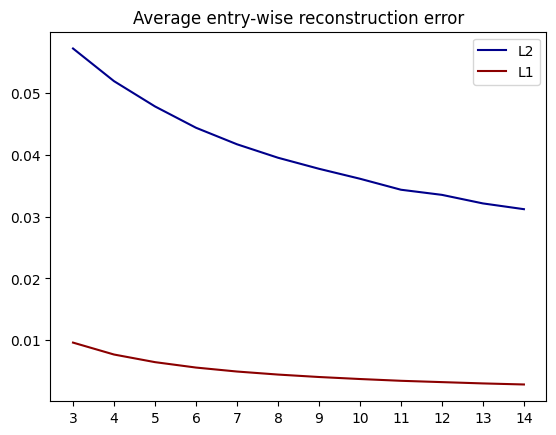

In [33]:
xticks = [d for d in range(3,D)]
plt.figure()

plt.title('Average entry-wise reconstruction error')
plt.plot(xticks,avg_L2, color='darkblue', label='L2')
plt.plot(xticks,avg_L1, color='darkred', label='L1')
plt.xticks(xticks)
plt.legend()

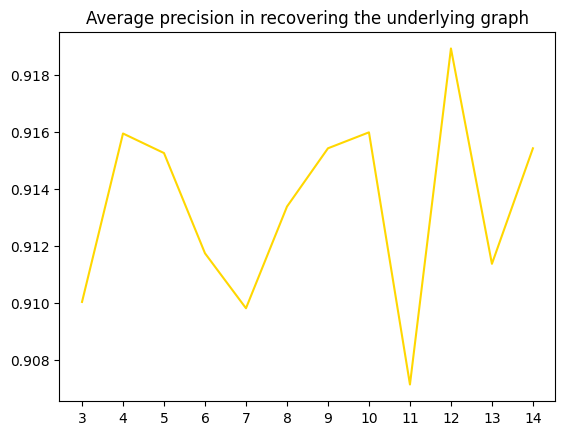

In [37]:
plt.figure()

plt.title('Average precision in recovering the underlying graph')
plt.plot(xticks, sparsAcc, color='gold')
plt.xticks(xticks)
plt.show()